# Random Forest Model

RF is one of the models we applied to predict deaths for COVID-patients in Mexico.
It is worth noting that the data is highly imbalanced, and Random Forest doesn't work well with imbalanced data because it aims to minimize the overall error rate, rather than paying special attention to the positive class.
To alleviate the problem, we follow two proposed models by [Chen et al (2004)](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf): balanced random forest (BRF) and weighted random forest (WRF).

In [16]:
import pre_ml
import mlpipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install -U imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix

In [ ]:
df = pre_ml.data(False)
df.head(10)

## 1. Pre-process

### 1.1 Split data and define features/target variables

In [82]:
#1st Step: Split
train, test = mlpipeline.split_data(df, test_size=0.2, seed=0)
print('Training data observations:{}'.format(train.shape[0]))
print('Testing data observations:{}'.format(test.shape[0]))
print('Training observations of Deaths=1 and no Deaths=0')
print(train['muertos'].value_counts())

Training data observations:67701
Testing data observations:16926
Training observations of Deaths=1 and no Deaths=0
0    60209
1     7492
Name: muertos, dtype: int64


_As seen in the data, only 11% corresponds to one label. When doing Cross Validation, some samples may not have the label = 1 in their data. So, we must take into account some balance techniques._

In [83]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target = ['muertos']

## 2. Model Learning and Evaluation: Random Forest

### 2.2 Balanced Random Forest Classifier
From [Chen et al (2004)](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf), 
the BRF algorithm works as follows:  
1. For each iteration in random forest, draw a bootstrap sample from the minority class. Randomly draw the same number of cases, with replacement, from the majority class.
2. Induce a classification tree from the data to maximum size, without pruning. The tree is induced with the CART algorithm, with the following modification: At each node, instead of searching through all variables for the optimal split, only search through a set of m randomly selected variables.
3. Repeat the two steps above for the number of times desired. Aggregate the predictions of the ensemble and make the final prediction.

In [263]:
from sklearn.model_selection import GridSearchCV
params = {'criterion':['gini', 'entropy'], 'max_depth':[10, 15],
         'min_samples_split':[10, 15]}       
grid_brf = GridSearchCV(estimator=BalancedRandomForestClassifier(random_state=0), 
                          param_grid=params, 
                          cv=5,
                          return_train_score=True,
                          scoring=['recall', 'precision'],
                           refit = 'recall')

In [264]:
grid_brf.fit(train[features],train[target].values.ravel())
brf_results = pd.DataFrame(grid_brf.cv_results_)

In [265]:
pd.set_option('mode.chained_assignment', None)
cols_to_keep = ['param_criterion','param_max_depth', 'param_min_samples_split', 'rank_test_recall'
                ,'mean_test_recall','mean_train_recall', 'mean_test_precision','mean_train_precision']
brf_results = brf_results[cols_to_keep]
brf_results.rename(columns = {'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
brf_results.sort_values(by='rank_test_recall')

,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
1,gini,10,15,1,0.802455,0.830119,0.226901,0.235009
4,entropy,10,10,2,0.802054,0.831320,0.226984,0.235324
5,entropy,10,15,3,0.800988,0.828684,0.227073,0.234925
0,gini,10,10,4,0.800186,0.831987,0.226963,0.235581
2,gini,15,10,5,0.794581,0.863588,0.229724,0.250105
3,gini,15,15,6,0.794181,0.854611,0.230207,0.247562
7,entropy,15,15,7,0.792845,0.852543,0.229686,0.246950
6,entropy,15,10,8,0.792713,0.861018,0.229824,0.249269


Best Balanced Random Forest Model: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 15}
Model's Accuracy on test data: 0.67
Model's Precision on test data: 0.23
Model's Recall on test data: 0.81
Model's F1 Score: 0.359


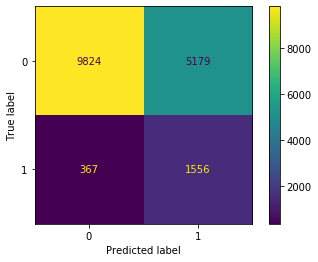

In [266]:
print('Best Balanced Random Forest Model: {}'.format(grid_brf.best_params_))
y_pred = grid_brf.predict(test[features])
plot_confusion_matrix(grid_brf.best_estimator_, test[features],test[target])
print("Model's Accuracy on test data: {}".format(round(accuracy_score(test[target], y_pred),2)))
print("Model's Precision on test data: {}".format(round(precision_score(test[target], y_pred),2)))
print("Model's Recall on test data: {}".format(round(recall_score(test[target], y_pred),2)))
print("Model's F1 Score: {}".format(round(f1_score(test[target], y_pred),3)))

### 2.2 Weighted Random Forest Classifier

The regular RF classifier tends to be biased towards the majority class, so the weighted random forest places a heavier penalty on misclassifying the minority class (i.e. the minority class is given a larger weight). 
The weights are used in the tree induction procedure (the splits) and in the terminal nodes (class determined by weighted majority vote).

For more applied models for imbalanced data: [link](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/)

In [213]:
params = {'criterion':['gini', 'entropy'], 'max_depth':[10, 15],'class_weight':['balanced', 'balanced_subsample'],
         'min_samples_split':[10, 15]}       
grid_wrf = GridSearchCV(estimator=RandomForestClassifier(random_state=0), 
                          param_grid=params, 
                          cv=5,
                          return_train_score=True,
                          scoring=['recall', 'precision'],
                           refit = 'recall')

In [216]:
grid_wrf.fit(train[features],train[target].values.ravel())
wrf_results = pd.DataFrame(grid_wrf.cv_results_)

In [219]:
cols_to_keep = ['param_class_weight','param_criterion','param_max_depth', 'param_min_samples_split', 
                'rank_test_recall','mean_test_recall','mean_train_recall', 
                'mean_test_precision','mean_train_precision']
wrf_results = wrf_results[cols_to_keep]
wrf_results.rename(columns = {'param_class_weight':'class_weight',
                            'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
wrf_results.sort_values(by='rank_test_recall')

,class_weight,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
5,balanced,entropy,10,15,1,0.758010,0.812633,0.236640,0.253787
9,balanced_subsample,gini,10,15,2,0.757476,0.819174,0.235732,0.254543
1,balanced,gini,10,15,3,0.756274,0.816738,0.235872,0.254505
8,balanced_subsample,gini,10,10,4,0.756141,0.819774,0.235950,0.254906
13,balanced_subsample,entropy,10,15,5,0.756008,0.813868,0.235541,0.253879
0,balanced,gini,10,10,6,0.754138,0.818006,0.236863,0.256333
12,balanced_subsample,entropy,10,10,7,0.752270,0.815536,0.235578,0.255030
4,balanced,entropy,10,10,8,0.750401,0.814268,0.235853,0.255639
15,balanced_subsample,entropy,15,15,9,0.656033,0.828984,0.257537,0.323686
7,balanced,entropy,15,15,10,0.655366,0.829485,0.257999,0.324130


Best Balanced Random Forest Model: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}
Model's Accuracy on test data: 0.7
Model's Precision on test data: 0.24
Model's Recall on test data: 0.77
Model's F1 Score: 0.366


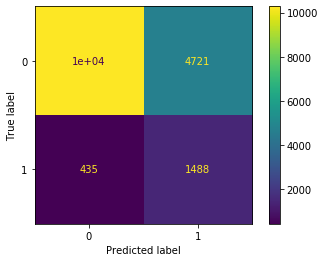

In [225]:
print('Best Balanced Random Forest Model: {}'.format(grid_wrf.best_params_))
y_pred = grid_wrf.predict(test[features])
plot_confusion_matrix(grid_wrf.best_estimator_,test[features],test[target])
print("Model's Accuracy on test data: {}".format(round(accuracy_score(test[target], y_pred),2)))
print("Model's Precision on test data: {}".format(round(precision_score(test[target], y_pred),2)))
print("Model's Recall on test data: {}".format(round(recall_score(test[target], y_pred),2)))
print("Model's F1 Score: {}".format(round(f1_score(test[target], y_pred),3)))

## 3. Feature Importance

From BalanceRF and Weighted RF models, we show the features' importances to predict deaths for COVID-19 patients.

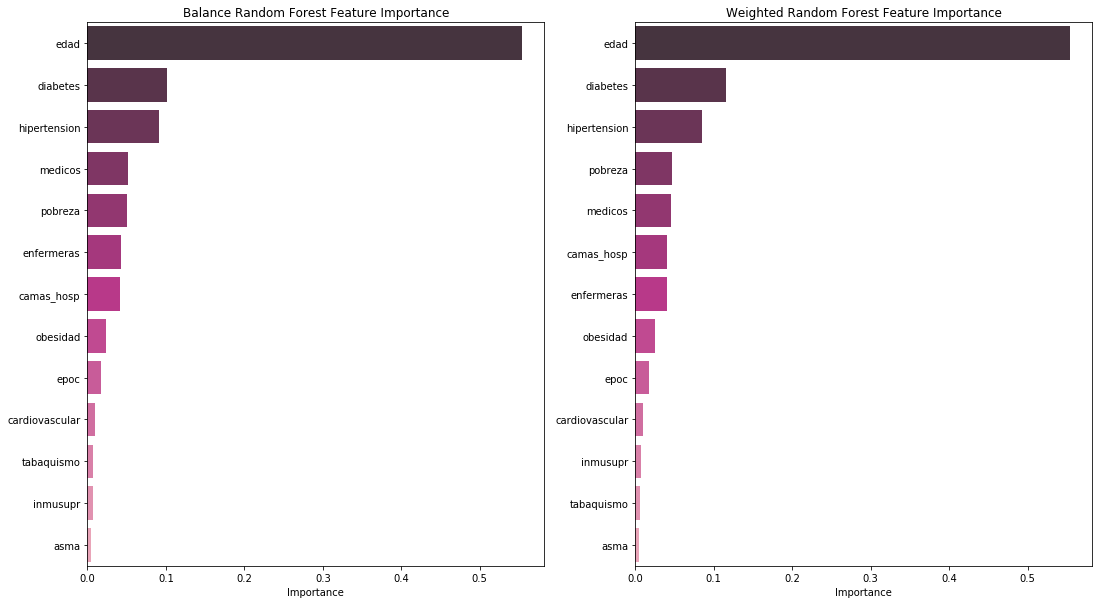

In [291]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
for model, subplot in [(grid_brf.best_estimator_, ax1), (grid_wrf.best_estimator_, ax2)]:
    importances = model.feature_importances_
    fi = pd.DataFrame(data={'Features': features, 
                        'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Features', data=fi, palette="RdPu_d", ax=subplot)
    subplot.set_xlabel('Importance')
    subplot.set_ylabel('')
    if subplot == ax1:
        subplot.set_title('Balance Random Forest Feature Importance')
    else:
        subplot.set_title('Weighted Random Forest Feature Importance')
